# Background

Search is built around the vector space model of text. 

In [1]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import scipy
import spacy
%matplotlib inline

In [2]:
MINI_CORPUS = [
    ("D1", "Human machine interface for computer applications"),
    ("D2", "A survey of user opinion of computer system response time"),
    ("D3", "The EPS user interface management system"),
    ("D4", "System and human system engineering testing of EPS"),
    ("D5", "The generation of random, binary, and ordered trees"),
    ("D6", "The intersection graph of paths in trees"),
    ("D7", "Graph minors: A survey")
]

In [3]:
nlp = spacy.load("en")

In [4]:
def analyzer(text):
    """ split by word, remove stopwords and lowercase """
    return [tok.text for tok in nlp(text.lower()) if not tok.is_stop]

def show_matrix(M, vocab, title):
    """ visualize matrix as a heat map """
    if scipy.sparse.issparse(M):
        M = M.todense()
    M = np.round(M, 3)
    vocab_r = {v:k for k, v in vocab.items()}
    num_docs, num_words = M.shape
    plt.figure(figsize=(5, 10))
    plt.imshow(M)
    plt.xticks(np.arange(num_words), [vocab_r[x] for x in np.arange(num_words)], rotation="45")
    plt.yticks(np.arange(num_docs), ["D" + str(x+1) for x in np.arange(num_docs)])
    for i in range(num_docs):
        for j in range(num_words):
            text = plt.text(j, i, M[i, j], ha="center", va="center", color="w")
    plt.title(title)
    plt.show()

In [5]:
texts = [text for title, text in MINI_CORPUS]

## Raw Frequencies

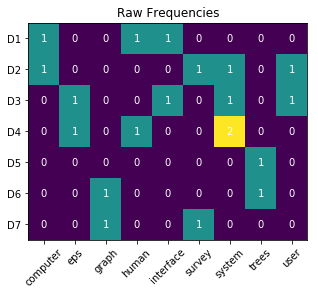

In [6]:
count_vectorizer = CountVectorizer(analyzer=analyzer, min_df=2)
M_raw = count_vectorizer.fit_transform(texts)
vocab = count_vectorizer.vocabulary_
show_matrix(M_raw, vocab, "Raw Frequencies")

## Term Frequencies

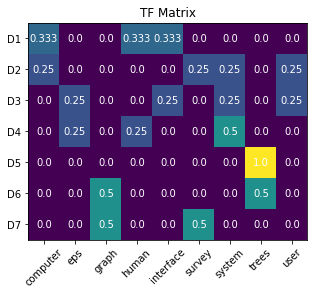

In [7]:
tf_vectorizer = TfidfVectorizer(analyzer=analyzer, vocabulary=vocab, use_idf=False, min_df=2, norm="l1")
M_tf = tf_vectorizer.fit_transform(texts)
show_matrix(M_tf, vocab, "TF Matrix")

## Term Frequency + Inverse Document Frequency

$$idf(t, D) = log \frac {N}{|t \in D|}$$

where numerator is N = number of documents in corpus and denominator is number of documents term t appears in.

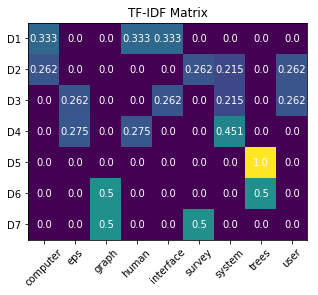

In [8]:
tfidf_vectorizer = TfidfVectorizer(analyzer=analyzer, vocabulary=vocab, use_idf=True, 
                                   smooth_idf=False, min_df=2, norm="l1")
M_tfidf = tfidf_vectorizer.fit_transform(texts)
show_matrix(M_tfidf, vocab, "TF-IDF Matrix")

In [9]:
V_idf = tfidf_vectorizer.idf_
V_idf

array([2.25276297, 2.25276297, 2.25276297, 2.25276297, 2.25276297,
       2.25276297, 1.84729786, 2.25276297, 2.25276297])

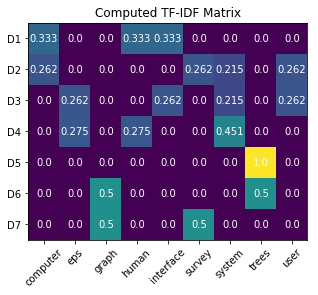

In [10]:
M_tfidf_comp = np.multiply(M_tf.todense(), V_idf)
M_tfidf_comp_norm = np.sum(M_tfidf_comp, axis=1)
M_tfidf_comp = np.divide(M_tfidf_comp, M_tfidf_comp_norm)
show_matrix(M_tfidf_comp, vocab, "Computed TF-IDF Matrix")

## Inverted Index

In [11]:
def search(term, vocab, M):
    if term not in vocab.keys():
        return []
    col_idx = vocab[term]
    doc_weights = np.array(M.todense()[:, col_idx].squeeze())
    doc_ids = np.argsort(-doc_weights)
    results = []
    for j in range(doc_weights.shape[1]):
        doc_id = doc_ids[0][j]
        if doc_weights[0][doc_id] == 0:
            break
        results.append(("D" + str(doc_id + 1), doc_weights[0][doc_id]))
    return results

print("search results for 'interface'")
print(search("interface", vocab, M_tfidf))
print("search results for 'system'")
search("system", vocab, M_tfidf)

search results for 'interface'
[('D1', 0.3333333333333333), ('D3', 0.26177912439730705)]
search results for 'system'


[('D4', 0.45055376919631346),
 ('D2', 0.2146626268080788),
 ('D3', 0.2146626268080788)]

## Dimensionality Reduction

We factorize our original TD matrix into three matrices U, S and V. Here S is a diagonal matrix. The factorization moves the components with the most effect to the top of S. Reconstructing the matrix with a truncated S will give us an approximation of the original matrix which often exposes latent relationships between terms, and is used for "semantic search" applications.

$$M = USV^T \approx UsV^T$$

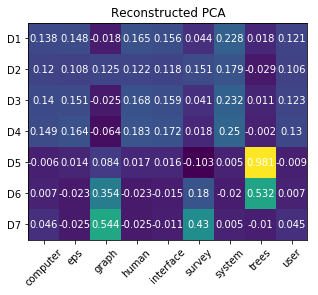

In [12]:
pca = PCA(n_components=2)
M_red = pca.fit_transform(M_tfidf.todense())
M_pca = pca.inverse_transform(M_red)
show_matrix(M_pca, vocab, "Reconstructed PCA")